# Interactive Transects

This notebook illustrates how to make transects of tsunami depth over topography that can be interactively updated by selecting the transect.  

For this demo we use the same test data as used in Visualization Tutorial notebook `Crescent_City_Inundation.ipynb`, but it should work also with other combinations of topography and depth data.


### First set up some things needed in notebook....

In [1]:
% pylab inline
% matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import sys, os

from scipy.interpolate import RegularGridInterpolator
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
from IPython.display import HTML
from numpy import ma

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import data_tools

data_dir = 'data' #/data/CCtimeframes'
# check that directory exists, raise an exception if not:
assert os.path.isdir(data_dir), '*** Data directory not found'

Here we're defining a bunch of functions used throughout the notebook. Optimally we'd want to import these like 'data_tools' as a local package, but since we're iterating in the notebook right now it's easier to have them all here...

In [18]:
###### Plot topo over depth ######

def discrete_cmap_1(clines):
    """
    Construct a discrete color map for the regions between the contour lines
    given in clines. Colors go from turqouise through yellow to red.
    Good for flooding depth.
    """
    from numpy import floor, linspace, hstack, ones, zeros
    nlines = len(clines)
    n1 = int(floor((nlines-1)/2.))
    n2 = nlines - 1 - n1
    Green = hstack([linspace(1,1,n1),linspace(1,0,n2)])
    Red = hstack([linspace(0,0.8,n1), ones(n2)])
    Blue = hstack([linspace(1,0.2,n1), zeros(n2)])
    colors = list(zip(Red,Green,Blue))
    return colors

def plot_topo_and_depth(ax=None):
    if ax is None:
        fig = figure(figsize=(6,6))
        ax = axes()
    topo_clines = arange(0,20,2)
    ax.contour(X,Y,topo,topo_clines,colors='k')
    ax.contourf(X,Y,hmax_onshore, depth_contour_levels, 
             colors = depth_colors, extend='max')
    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=20 )
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude");

    
###### Interactive Plotting ######

class DrawLine:
    def __init__(self, fig,ax1,ax2,ax3,hmax_func,topo_func):
        self.figure = fig
        self.ax1 = ax1
        self.ax2 = ax2
        self.ax3 = ax3
        self.xprev = 0
        self.yprev = 0
        self.xnew = 0
        self.ynew = 0
        self.press = None
        self.hmax_func = hmax_func
        self.topo_func = topo_func

    def connect(self):
        'connect to all the events we need'
        self.cidpress = self.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)

    def on_press(self, event):
        
        self.xprev = event.xdata
        self.yprev = event.ydata
        self.press = 1
        
        self.ax1.lines = []
        if len(self.ax1.texts) > 0:
            self.ax1.texts.remove(self.ax1.texts[0])
        if len(self.ax1.texts) > 0:
            self.ax1.texts.remove(self.ax1.texts[0])
        plt.draw()
        
        self.ax1.plot(self.xprev,self.yprev,'bo')
        self.ax1.text(self.xprev,self.yprev-.0012, r'A', fontsize=12,fontweight='bold',
                      bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},ha='center', va='center')
        
        self.figure.canvas.draw()

    def on_release(self, event):
        self.press = None
        self.xnew = event.xdata
        self.ynew = event.ydata
              
        # self.plot1.remove()      
        # self.ax1.cla()  # clear the old transect

        # replot topo and water depth:
        # plot_topo_and_depth(ax1)
        
        # self.ax1.add_image(tiles,15)
        # self.ax1.contour(X,Y,topo,topo_clines, colors='k',opacity=0.5)
        # CClatitude = 41.75  # to rescale longitude
        # self = ax1.set_aspect(1. / cos(pi*CClatitude/180.)) 
        
        # add transect plot:
        self.plot_transect()
        
        # plot red line between points selected:
        self.ax1.plot([self.xprev,self.xnew],[self.yprev,self.ynew],'b-o',lw=3)
        
        self.ax1.text(self.xnew,self.ynew+.0012, r'B', fontsize=12,fontweight='bold',
                      bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},ha='center', va='center')

        self.figure.canvas.draw() 
        
    def disconnect(self):
        'disconnect all the stored connection ids'
        self.figure.canvas.mpl_disconnect(self.cidpress)
        self.figure.canvas.mpl_disconnect(self.cidrelease)
        
    def plot_transect(self):
        # points on transect:
        xi = linspace(self.xprev, self.xnew, 1000)
        yi = linspace(self.yprev, self.ynew, 1000)
        
        # evaulate topo and zeta on transect:
        Bi = self.topo_func(list(zip(xi,yi)))
        zi = self.hmax_func(list(zip(xi,yi)))
                
        # define surface eta as water depth + topography 
        eta = zi+Bi
    
        # Clear axis 2
        self.ax2.cla()
    
        # plot vs. longitude or latitude depending on orientation:
        if (abs(self.xnew-self.xprev) > 0.5*abs(self.ynew-self.yprev)):
            ti = xi
            self.ax2.set_xlim(min(self.xprev,self.xnew),max(self.xprev,self.xnew))
            xtext = 'Longitude'
        else:
            ti = yi
            self.ax2.set_xlim(min(self.yprev,self.ynew),max(self.yprev,self.ynew))
            xtext = 'Latitude'
            
        BiPos = where(Bi<0, 0., Bi)
        BiNeg = where(Bi>0, 0, Bi)
        
        
        self.ax2.fill_between(ti, BiPos, eta, color=[38./255,143./255,172./255])       # flood water
        self.ax2.fill_between(ti, BiNeg, 0, color=[63./255,183./255,200./255])   # original water
        self.ax2.fill_between(ti, -1e6, Bi, color=[235./255,212./255,167./255])   # topography
        self.ax2.plot(ti, Bi, 'k', lw=1)                       # topography
        self.ax2.plot(ti, eta, 'k', lw=1)
        
        self.ax2.set_xlabel(xtext)
        self.ax2.set_ylabel('Elevation [m]')
        self.ax2.set_title('Cross-Section: Maximum Inundation vs. %s' % xtext)
    
        # choose limits of vertical axis to give nice plots:
        eta_wet_max = eta.max()  #where(zi>0, zi+Bi, 0).max()
        y2 = max(10,eta_wet_max)
        self.ax2.set_ylim(-5, y2)
        
        self.ax2.text(ti[0],y2+3, r'A', fontsize=12,fontweight='bold',
                      bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},ha='center', va='center')
        self.ax2.text(ti[-1],y2+3, r'B', fontsize=12,fontweight='bold',
                      bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},ha='center', va='center')
    
        self.ax2.ticklabel_format(format='plain',useOffset=False)
        
        self.ax3.cla() 
        # self.ax1.set_title('(%8.4f,%8.4f) to (%8.4f,%8.4f)' % (self.xprev,self.yprev,self.xnew,self.ynew))
        clust_data = np.array([[self.xprev,self.yprev],[self.xnew,self.ynew]])
        collabel=("Longitude", "Latitude")
        rowlabel=(" A ", " B ")
        ax3.axis('tight')
        ax3.axis('off')
        the_table = self.ax3.table(cellText=clust_data,colLabels=collabel,rowLabels=rowlabel,loc='center')
        the_table.set_fontsize(14)
        the_table.scale(1, 1.5)
        
    def return_endpoints(self):
        return self.xprev, self.xnew, self.yprev, self.ynew

    
###### Animation ######

def read_animation_frames(nframes):
    
    # Initialize based on first frame
    fname = 'depth_%s.asc' % str(0).zfill(4)
    depth_file = os.path.join(data_dir, fname)    
    depth_data_dict = data_tools.read_asc_file(depth_file, verbose=False)
    frameshape = np.shape(depth_data_dict['values'])
    depths = np.empty([frameshape[0], frameshape[1], nframes])
    depths[:,:,0] = depth_data_dict['values']
    
    # Continue for remaining frames
    for frameno in range(1,nframes):
        fname = 'depth_%s.asc' % str(frameno).zfill(4)
        depth_file = os.path.join(data_dir, fname)    
        depth_data_dict = data_tools.read_asc_file(depth_file, verbose=False)
        depths[:,:,frameno] = depth_data_dict['values']
    
    return depths

def calc_animation_transect(xprev,xnew,yprev,ynew,depths):
    
    nframes = np.shape(depths)[2]
    xi = linspace(xprev, xnew, 1000)
    yi = linspace(yprev, ynew, 1000)
    
    if (abs(xnew-xprev) > 0.5*abs(ynew-yprev)):
        ti = xi
        xtext = 'Longitude'
    else:
        ti = yi
        xtext = 'Latitude'
    
    # Interpolate the topo
    anim_topo_func = RegularGridInterpolator((animX[0,:], animY[:,0]), anim_topo.T)
    Bi = anim_topo_func(list(zip(xi,yi)))
    
    # In loop, interpolate the depths and calculate eta
    etas = np.empty((nframes, 1000))
    for frameno in range(nframes):
        depth = depths[:,:,frameno]
        depth_func = RegularGridInterpolator((animX[0,:], animY[:,0]), depth.T)
        zi = depth_func(list(zip(xi,yi)))
        etas[frameno, :] = zi+Bi

    return Bi, etas, ti, xtext

def create_animation(Bi, etas, ti, xtext):
    
    nframes = len(etas)

    # Set up the figure
    fig = plt.figure(figsize=(12,3))
    ax = plt.subplot(111)

    # Draw patch for land
    # First define codes that define the start, path, and closing of the patch
    codes_land = [path.Path.MOVETO] + [path.Path.LINETO]*1001 + [path.Path.CLOSEPOLY]
    # Define the vertices in pairs of (x,y)
    vertices_land = [(ti[0], -1e6)] + list(zip(ti,Bi)) + [(ti[-1], -1e6), (0,0)]
    vertices_land = np.array(vertices_land, float)

    # Feed to Path and PathPatch
    path_land = path.Path(vertices_land, codes_land)
    patch_land = patches.PathPatch(path_land, facecolor=[235./255,212./255,167./255], edgecolor='none')
    ax.add_patch(patch_land)

    # Draw patch for water between land and surface
    codes_water = [path.Path.MOVETO] + [path.Path.LINETO]*1999 + [path.Path.CLOSEPOLY]
    vertices_water = list(zip(ti,etas[0,:])) + list(zip(ti,Bi))[::-1] + [(0,0)]
    vertices_water = np.array(vertices_water, float)

    path_water = path.Path(vertices_water, codes_water)
    patch_water = patches.PathPatch(path_water, facecolor=[38./255,143./255,172./255], edgecolor='k')
    ax.add_patch(patch_water)
    
    y2 = max(10, max(Bi)+2)
    txt = ax.text(ti[500],y2-2,'Minutes since earthquake: {}'.format(0),ha='center')

    # Set zoom limits (very important!)
    ax.set_xlim(min(ti[0],ti[-1]),max(ti[0], ti[-1]))
    ax.set_ylim(-5, y2)   

    # Labels
    ax.set_xlabel(xtext)
    ax.set_ylabel('Elevation [m]')
    
    ax.text(ti[0],y2+2, r'A', fontsize=12,fontweight='bold',
                      bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},ha='center', va='center')
    ax.text(ti[-1],y2+2, r'B', fontsize=12,fontweight='bold',
                      bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},ha='center', va='center')
    
    ax.ticklabel_format(format='plain',useOffset=False)
    
    ax.set_title('Inundation with Time')

    # Animation updates the vertices corresponding to the water's surface
    def animate(i):
        vertices_water[0:1000, 1] = etas[i,:]
        txt.set_text('Minutes since earthquake: {}'.format(i*2))
        return [patch_water, txt, ]

    ani = animation.FuncAnimation(fig, animate, nframes, interval=8000/nframes, blit=True)
    
    return ani

Now we're reading in a bunch of data and creating masks, etc.

In [4]:
hmax_file = '../geoclaw_output/hmax_CC.asc'
hmax_data_dict = data_tools.read_asc_file(hmax_file, verbose=False)

topo_file = '../geoclaw_output/topo_CC.asc'
topo_data_dict = data_tools.read_asc_file(topo_file, verbose=False)

# Read in topography for the animation so it's on the same grid as the animated frames
anim_topo_file = os.path.join(data_dir,'topo.asc')
anim_topo_data_dict = data_tools.read_asc_file(anim_topo_file, verbose=False)

topo = topo_data_dict['values']
hmax = hmax_data_dict['values']
anim_topo = anim_topo_data_dict['values']

X = hmax_data_dict['X']
Y = hmax_data_dict['Y']
animX = anim_topo_data_dict['X']
animY = anim_topo_data_dict['Y']

# Make available for interpolation
topo_func = RegularGridInterpolator((X[0,:], Y[:,0]), topo.T)
anim_topo_func = RegularGridInterpolator((animX[0,:], animY[:,0]), anim_topo.T)

# mask out the dry cells (e.g., where depth < 1 mm):
hmax_dry = ma.masked_where(hmax < 0.001, hmax)
# mask out the water region if we only care about onshore:
hmax_onshore = ma.masked_where(topo < 0, hmax_dry)

depth_contour_levels = np.arange(0,4.5,0.5)  # every 0.5 m up to 4 m
depth_colors = discrete_cmap_1(depth_contour_levels)

# Read in depth data for animation
depths = read_animation_frames(61)

### Create basemap for interactive plot

Saves image from OpenStreetMap tiles to local file, which is then read in later

<IPython.core.display.Javascript object>


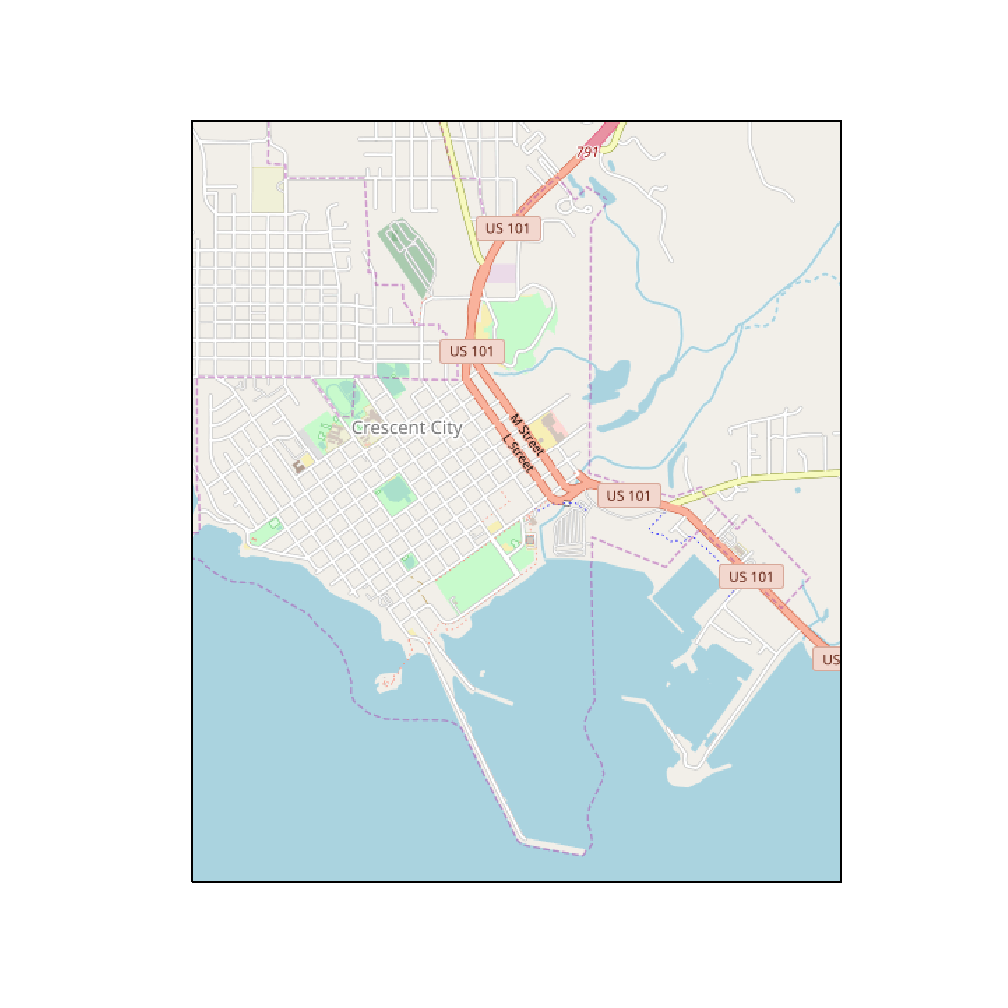

In [6]:
ext = [-124.215,-124.175,41.735,41.77]
A = tiles = cimgt.OSM()
plt.figure(figsize=(7,7))
ax = plt.axes(projection=tiles.crs)
ax.set_extent(ext)
ax.add_image(tiles,14)
plt.savefig("street_view_2", dpi=500, bbox_inches='tight', pad_inches=0)

## Execute the next cell to start the interactive plot...
**Note:** To use this, click on a point in the map, drag the mouse, and then release.  The points and transect do not show up until you release.  It would be nice if they did.

<IPython.core.display.Javascript object>


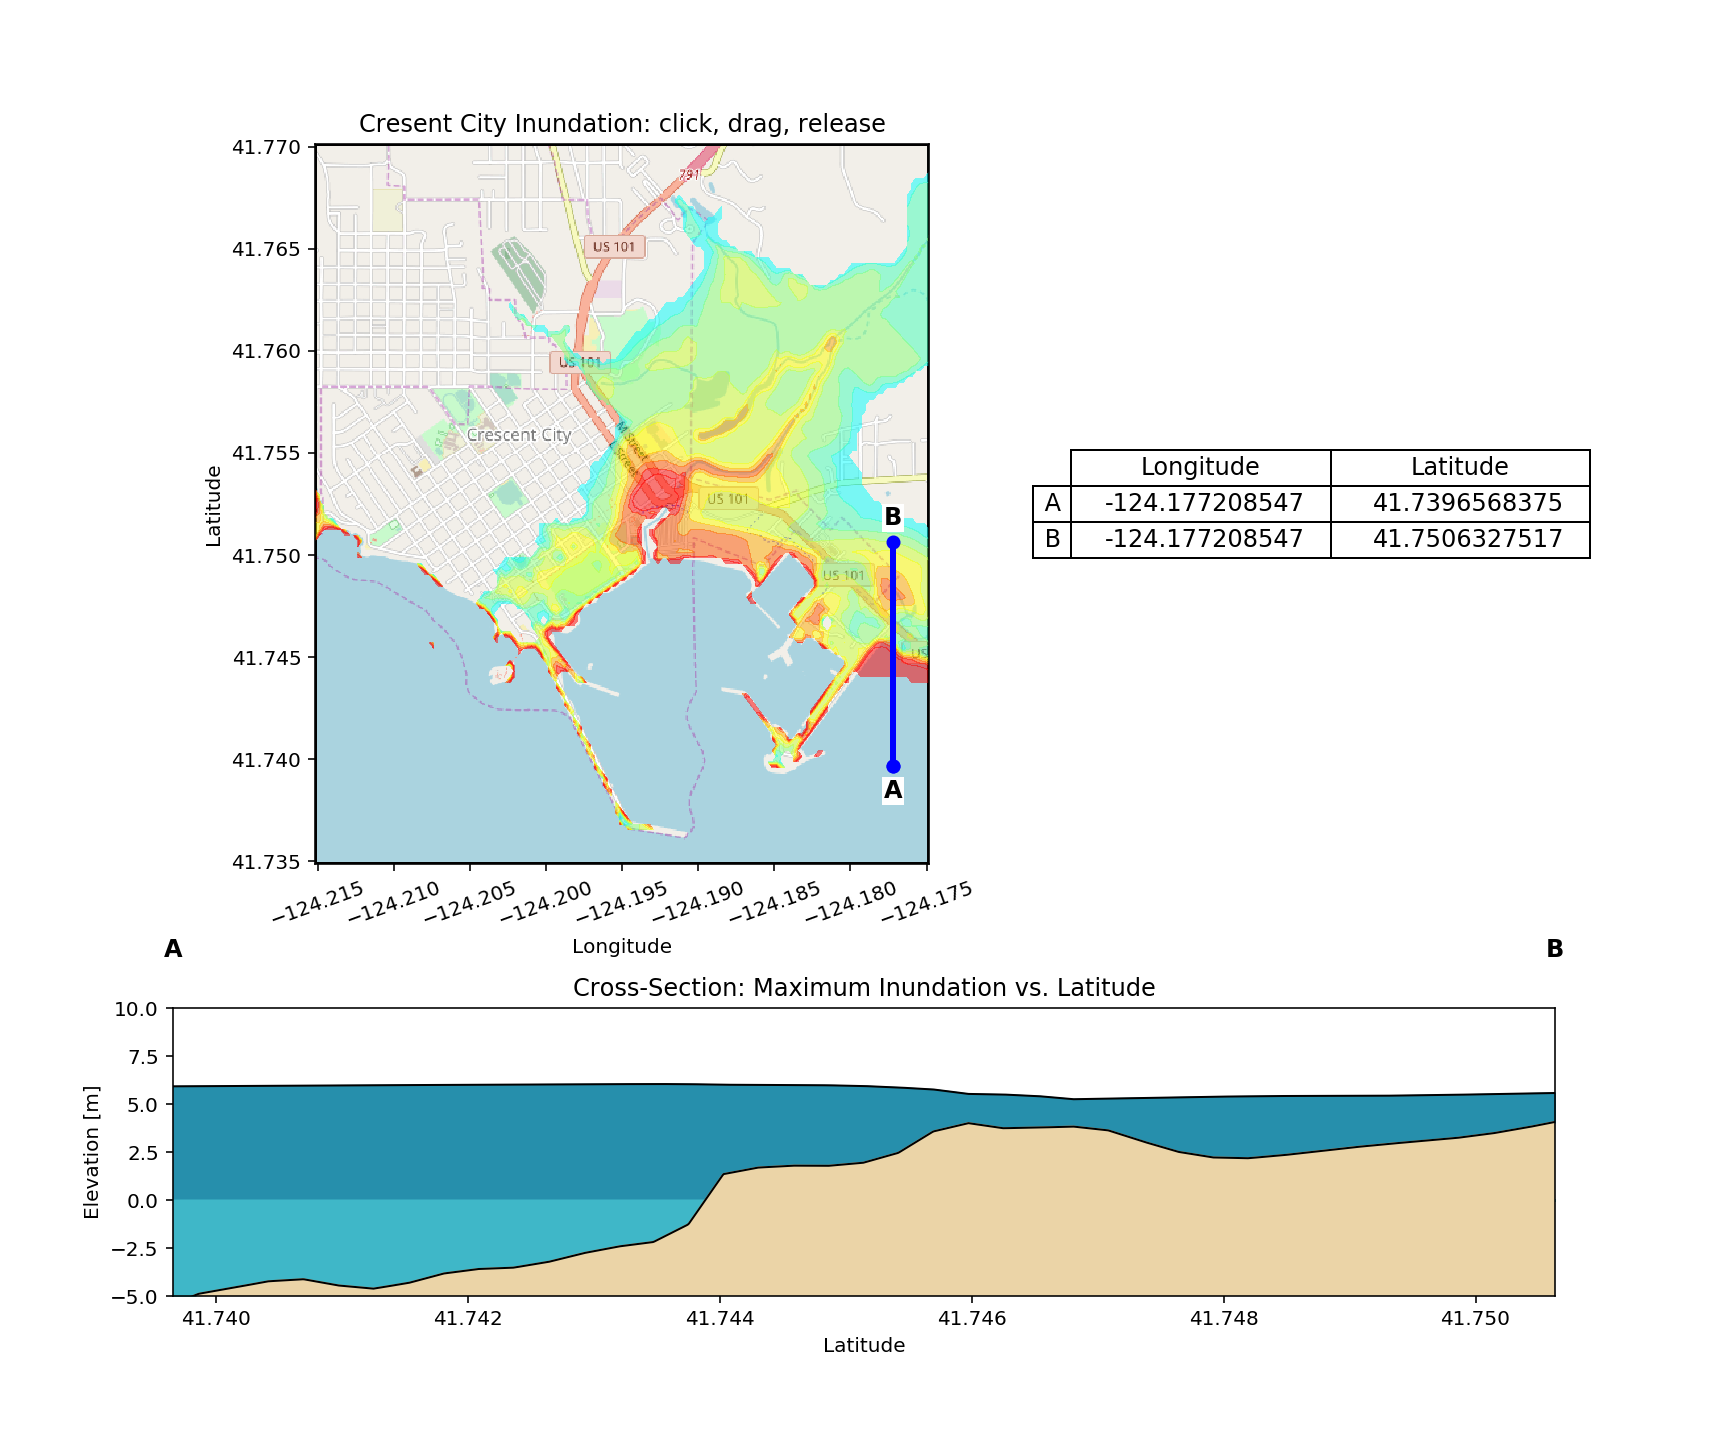

In [19]:
hmax_func = RegularGridInterpolator((X[0,:], Y[:,0]), hmax.T)

# gs = gridspec.GridSpec(12, 4) # define a grid over which to plot 
# fig = plt.figure(figsize=(12,12))
# create figure 1 specifications 
# ax1 = plt.subplot(gs[0:9,0:2])

fig = plt.figure(figsize=(12,10))
ax1 = plt.axes([.01,.4,.7,.5])

# ax = plt.axes(projection=tiles.crs)
# ax1.set_extent(ext)
# ax1.add_image(tiles,15)
CCimage = plt.imread('street_view_2.png')
# image_extent = (X.min(),X.max(),Y.min(),Y.max()) 
plt.imshow(CCimage, extent = (X.min(),X.max(),Y.min(),Y.max()));
CClatitude = 41.75  # to rescale longitude
ax1.set_aspect(1. / cos(pi*CClatitude/180.)) 

topo_clines = arange(0,20,2)
# ax1.contour(X,Y,topo,topo_clines, colors='#808080',linewidth=1,opacity=0.5)
ax1.contourf(X,Y,hmax_onshore, depth_contour_levels,colors = depth_colors, extend='max',alpha = 0.5)

# topo_clines = arange(0,20,2)
# ax1.contour(X,Y,topo,topo_clines,colors='k')

# ax1.contourf(X,Y,hmax_onshore, depth_contour_levels,colors = depth_colors, extend='max')
ax1.ticklabel_format(format='plain',useOffset=False)
#plt.xticks(rotation=20)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("Cresent City Inundation: click, drag, release")

# ax2 = plt.subplot(gs[10:,0:])
ax2 = plt.axes([.1,.1,.8,.2])

# ax3 = plt.subplot(gs[0:6,2:4])
ax3 = plt.axes([.62,.5,.3,.3])
clust_data = np.array([[1,2],[3,4]])
collabel=("Longitude", "Latitude")
rowlabel=(" A ", " B ")
ax3.axis('tight')
ax3.axis('off')
the_table = ax3.table(cellText=clust_data,colLabels=collabel,rowLabels=rowlabel,loc='center')
the_table.set_fontsize(14)
the_table.scale(1, 1.5)

plt.setp( ax1.xaxis.get_majorticklabels(), rotation=20 )
dr =  DrawLine(fig,ax1,ax2,ax3,hmax_func,topo_func)
dr.connect()

<IPython.core.display.Javascript object>


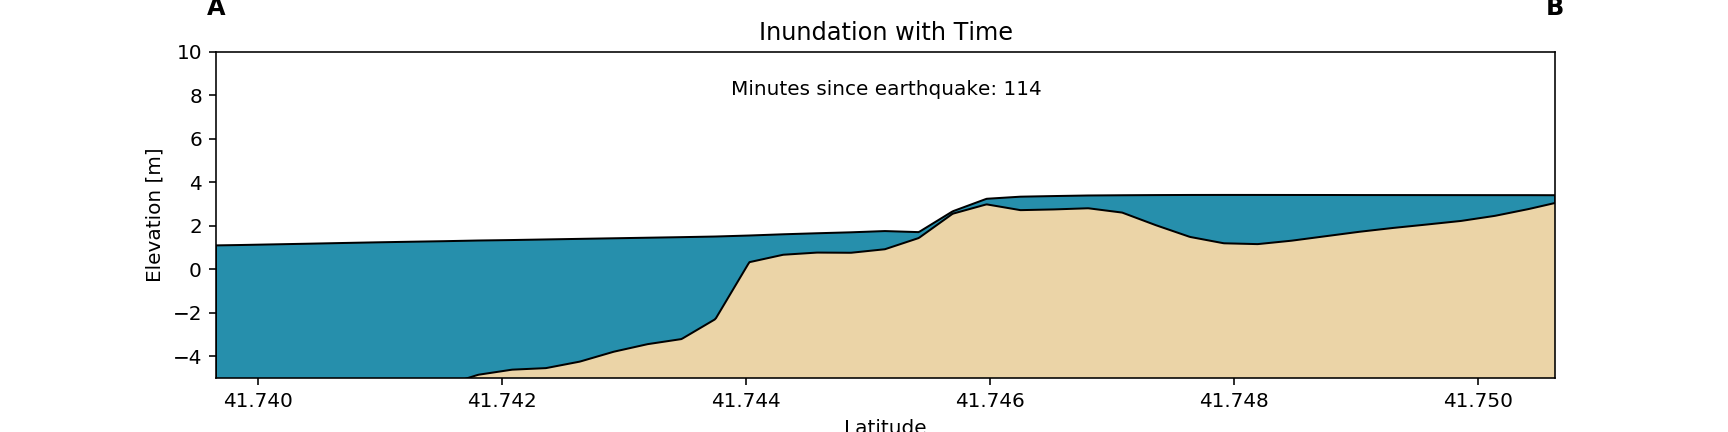

In [22]:
[xprev, xnew, yprev, ynew] = dr.return_endpoints()

# Calculate the transect
Bi, etas, ti, xtext = calc_animation_transect(xprev, xnew, yprev, ynew, depths)

# Run animation
ani = create_animation(Bi, etas, ti, xtext)